# <font color='blue'>SME0202 - Métodos Numéricos em Equações Diferenciais</font>

## Trabalho 1 - Equações Elípticas

#### Prof. Dr. Fabrício Simeoni de Sousa
ICMC-USP

**Aluno**: Vileno Cunha Cavalcante

# O Problema

Consideremos o problema estacionário no domínio retangular Ω = [0,1] × [-1,1], definido pela equação de convecção-difusão anisotrópica:

$$
\begin{align}
    &\frac{\partial^2 u}{\partial x^2} + 3\frac{\partial^2 u}{\partial y^2} = c\frac{\partial u}{\partial y} &&&&&&& (1)\\
\end{align}
$$

com as seguintes condições de contorno:

Nas fronteiras verticais $(x = 0$ e $x = 1)$:

$$
\begin{align}
    &u(0,y) = u(1,y) = 0 &&&& \forall y \in [-1,1] \\
\end{align}
$$

Nas fronteiras horizontais:

$$
\begin{align}
    &(\nabla u \cdot \mathbf{n})\big|_{(x,-1)} = e\sin(2\pi x) & \forall x \in [0,1] \\
    &(\nabla u \cdot \mathbf{n} + u)\big|_{(x,1)} = 0 & \forall x \in [0,1]
\end{align}
$$

Fixando $c = 4\pi^2 - 3$, a solução analítica particular para o problema é dada por:

$$
u(x,y) = e^{-y} \sin(2\pi x).
$$

\\

# Discretização do Problema

Para resolver este problema, aproximamos os termos de difusão e convecção da equação por diferenças finitas de segunda ordem. A equação discretizada para pontos internos do domínio é:

$$
\frac{u_{i+1,j} - 2u_{i,j} + u_{i-1,j}}{h^2} + 3\frac{u_{i,j+1} - 2u_{i,j} + u_{i,j-1}}{h^2} = c\frac{u_{i,j+1} - u_{i,j-1}}{2h}.
$$

As condições de contorno verticais são implementadas excluindo-se esses pontos da matriz. As condições de contorno são tratadas usando diferenças progressivas e regressivas de segunda ordem, respectivamente:

- Inferior $(\nabla u \cdot \mathbf{n})\big|_{(x,-1)} = e\sin(2\pi x)$: \\
\
$$
\frac{-3u_{i,0} + 4u_{i,1} - u_{i,2}}{2h} = e \sin(2\pi x_i)
$$

- Superior $(\nabla u \cdot \mathbf{n} + u)\big|_{(x,1)} = 0$: \\
\
$$
\frac{3u_{i,Ny-1} - 4u_{i,Ny-2} + u_{i,Ny-3}}{2h} + u_{i,Ny-1} = 0
$$

Transformando essas equações em um sistema discreto

$$A\vec{u}=\vec{b}$$

obtemos um método de aproximação para $(1)$, onde as linhas do sistema são dadas por:

$$
\left( \frac{1}{h^2} \right) u_{i+1,j}
+ \left( \frac{3}{h^2} + \frac{c}{2h} \right) u_{i,j+1}
+ \left( -\frac{8}{h^2} \right) u_{i,j}
+ \left( \frac{3}{h^2} - \frac{c}{2h} \right) u_{i,j-1}
+ \left( \frac{1}{h^2} \right) u_{i-1,j}
= b_{i,j}
$$

Ou, na forma matricial:

\begin{equation}
\underbrace{
\begin{bmatrix}
\ddots & \ddots & \ddots & 0 & 0 & 0 & 0 \\
\ddots & -8 & 1 & 3 + \frac{ch}{2} & 0 & 0 & 0 \\
0 & 3 - \frac{ch}{2} & 1 & -8 & 1 & 3 + \frac{ch}{2} & 0 \\
0 & 0 & 3 - \frac{ch}{2} & 1 & -8 & \ddots & \ddots \\
0 & 0 & 0 & \ddots & \ddots & \ddots & \ddots \\
0 & 0 & 0 & 0 & 3 - \frac{ch}{2} & 1 & -8 \\
0 & 0 & 0 & 0 & 0 & \ddots & \ddots
\end{bmatrix}
}_{\textbf{A}}
\underbrace{
\begin{bmatrix}
\\
\vdots \\
\\
u_{i-1,j} \\
u_{i,j} \\
u_{i+1,j} \\
\\
\vdots \\
\\
\end{bmatrix}
}_{\textbf{u}}
=
\underbrace{
\begin{bmatrix}
\\
\vdots \\
\\
\\
e \sin(2\pi x_i) \\
\\
\\
\vdots \\
\\
\end{bmatrix}
}_{\textbf{b}}
\end{equation}


# Implementação do Método

In [ ]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
from matplotlib import cm

In [ ]:
# Solução analítica
def u(x, y):
    return np.exp(-y) * np.sin(2 * np.pi * x)

def calcula_erros(v1, v2):
    error = np.abs(v1 - v2)
    return error, np.mean(error), np.max(error)

def preecher_matriz(A, b, c, x, y, h, Nx, Ny):
    for i in range(1, Nx - 1):
        for j in range(Ny):

            k = (i - 1) * Ny + j

            # Condição de contorno inferior
            if j == 0:
                A[k, k] = -3
                if j + 1 < Ny:
                    A[k, k + 1] = 4
                if j + 2 < Ny:
                    A[k, k + 2] = -1
                x_i = x[i]
                b[k] = -2 * h * np.exp(1) * np.sin(2 * np.pi * x_i)

            # Condição de contorno superior
            elif j == Ny - 1:
                A[k, k] = 3 + 2 * h
                if j - 1 >= 0:
                    A[k, k - 1] = -4
                if j - 2 >= 0:
                    A[k, k - 2] = 1
                b[k] = 0

            # Pontos internos
            else:
                # Termo i+1
                if i + 1 < Nx - 1:
                    vizinho = i * Ny + j
                    A[k, vizinho] += 1
                # Termo i-1
                if i - 1 >= 1:
                    vizinho = (i - 2) * Ny + j
                    A[k, vizinho] += 1
                # Termo j+1
                A[k, k + 1] += (3 - (c * h) / 2)
                # Termo j-1
                A[k, k - 1] += (3 + (c * h) / 2)
                # Termo central
                A[k, k] += -8


def solve_convection_diffusion(h, xi=0, xf=1, yi=-1, yf=1):
    # Parâmetro
    c = 4 * np.pi**2 - 3

    # Malha
    Nx = int(1/h) + 1
    Ny = int(2/h) + 1
    x = np.linspace(xi, xf, Nx)
    y = np.linspace(yi, yf, Ny)

    # Número de incógnitas
    n = (Nx - 2) * Ny

    # Inicializar matriz esparsa A e vetor b
    A = sp.lil_matrix((n, n))
    b = np.zeros(n)

    # Preencher a matriz A e o vetor b
    preecher_matriz(A, b, c, x, y, h, Nx, Ny)

    # Resolver o sistema
    u_solution = spla.spsolve(A.tocsr(), b)
    u_reshaped = u_solution.reshape((Nx - 2, Ny))

    # Incluir contornos Dirichlet
    u_numerical = np.zeros((Nx, Ny))
    u_numerical[1:-1, :] = u_reshaped

    # Gerar malha para plotagem
    X, Y = np.meshgrid(x, y, indexing='ij')

    return X, Y, u_numerical

In [ ]:
# Resolve o problema
h = 0.01
X, Y, u_num = solve_convection_diffusion(h)

# Análise Gráfica

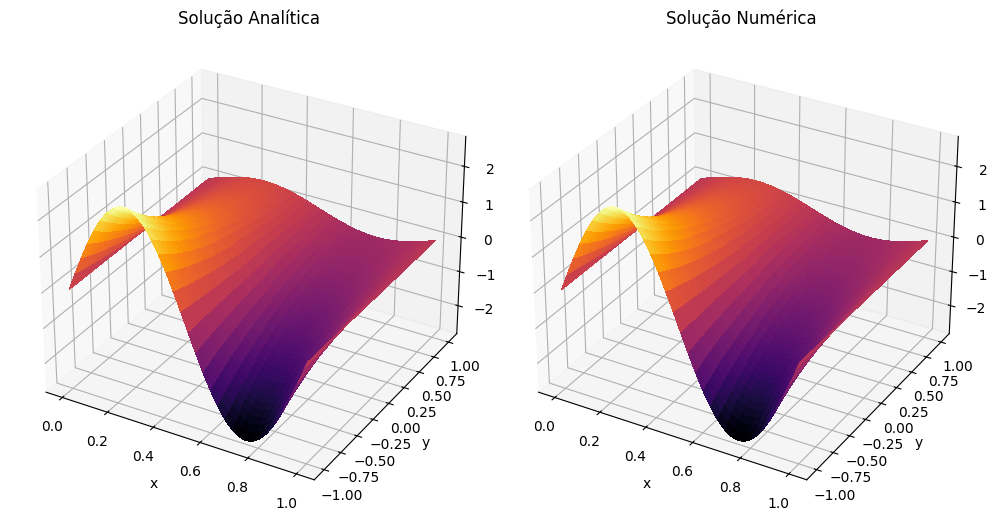

In [ ]:
# Vizualização dos gráficos

# Plotar superfície da solução analítica
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(121, projection='3d')
surf = ax.plot_surface(X, Y, u(X,Y), cmap='inferno', linewidth=0, antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u')
ax.set_title('Solução Analítica')

# Plotar superfície da solução numérica
ax = fig.add_subplot(122, projection='3d')
surf = ax.plot_surface(X, Y, u_num, cmap='inferno', linewidth=0, antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u')
ax.set_title('Solução Numérica')
plt.tight_layout()
plt.show()

# Análise do Erro

Fizemos uma análise do erro cometido pelo método, onde erro é dado pela diferença absoluta entre o valor exato (solução analítica) e a aproximação realizada pelo método

Erro máximo: 9.62e-04
Erro médio: 4.25e-04


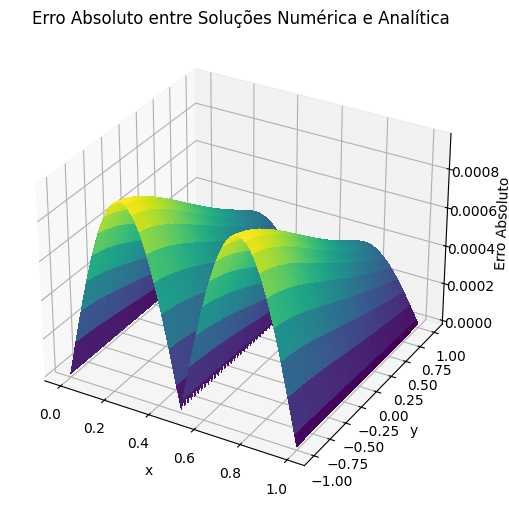

In [ ]:
# Calcular erro absoluto local
error, mean_error, max_error = calcula_erros(u(X, Y), u_num)

# Mostrar erro máximo e médio
print(f"Erro máximo: {max_error:.2e}")
print(f"Erro médio: {mean_error:.2e}")

# Plotar erro absoluto
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, error, cmap='viridis', linewidth=0, antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Erro Absoluto')
plt.title('Erro Absoluto entre Soluções Numérica e Analítica')
plt.show()

# Análise de Convergente

A taxa de convergência numérica foi estimada utilizando a seguinte expressão:

$$
\text{Taxa} = \frac{log (E_{i+1}) - log(E_i)}{log(h_{i+1}) - log(h_{i})}
$$

onde:
- $E_i$ é o erro (máximo ou médio) associado à malha de passo $h_i$,
- $E_{i+1}$ é o erro associado à malha mais refinada de passo $h_{i+1}$,
- $h_i$ e $h_{i+1}$ são os tamanhos dos elementos da malha.


Taxa de convergência (Erro Máximo): 1.97
Taxa de convergência (Erro Médio): 1.98


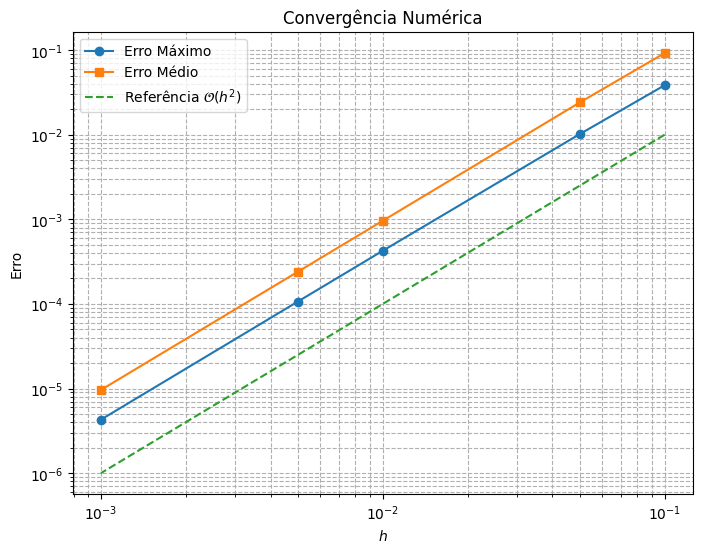

In [ ]:
# Lista de espaçamentos h
h_list = [0.1, 0.05, 0.01, 0.005, 0.001]
max_errors = []
mean_errors = []

# Loop sobre diferentes valores de h
for h in h_list:
    # Resolve o probelma
    X, Y, u_numerical = solve_convection_diffusion(h)

    # Calcular erros
    error, mean_error, max_error = calcula_erros(u(X, Y), u_numerical)
    max_errors.append(mean_error)
    mean_errors.append(max_error)

# Calcular taxa de convergência
rates_max = np.diff(np.log(max_errors)) / np.diff(np.log(h_list))
rates_mean = np.diff(np.log(mean_errors)) / np.diff(np.log(h_list))
print(f"Taxa de convergência (Erro Máximo): {rates_max.mean():.2f}")
print(f"Taxa de convergência (Erro Médio): {rates_mean.mean():.2f}")

# Plotar resultados em escala log-log
plt.figure(figsize=(8, 6))
plt.loglog(h_list, max_errors, 'o-', label='Erro Máximo')
plt.loglog(h_list, mean_errors, 's-', label='Erro Médio')
plt.loglog(h_list, [h**2 for h in h_list], '--', label='Referência $\mathcal{O}(h^2)$')
plt.xlabel('$h$')
plt.ylabel('Erro')
plt.title('Convergência Numérica')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()